In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

**LOADING THE DATASET**

In [2]:
import os

folder_path = r"C:\Users\fastf\Downloads\Solid_waste_Dataset"
print(os.listdir(folder_path))


['boralasgamuwa_2012-2018.csv', 'dehiwala_2012-2018.csv', 'homagama_2012-2018.csv', 'moratuwa_2014-2018.csv', 'open_source_austin_daily_waste_2003_jan_2021_jul.csv', 'open_source_ballarat_daily_waste_2000_jul_2015_mar.csv']


In [3]:
import glob, os

folder = r"C:\Users\fastf\Downloads\Solid_waste_Dataset"
all_files = glob.glob(os.path.join(folder, "*.csv"))

df_list = []
for f in all_files:
    city_name = os.path.basename(f).split("_")[0]  
    temp = pd.read_csv(f)
    temp["city"] = city_name
    df_list.append(temp)

data = pd.concat(df_list, ignore_index=True)
print(data.head())
print(data["city"].unique())


               area ticket_date waste_type  net_weight_kg           city
0  Boralesgamuwa UC  2012-01-01        MSW        17340.0  boralasgamuwa
1  Boralesgamuwa UC  2012-01-02        MSW        25980.0  boralasgamuwa
2  Boralesgamuwa UC  2012-01-03        MSW        29220.0  boralasgamuwa
3  Boralesgamuwa UC  2012-01-04        MSW         7450.0  boralasgamuwa
4  Boralesgamuwa UC  2012-01-05        MSW        10520.0  boralasgamuwa
['boralasgamuwa' 'dehiwala' 'homagama' 'moratuwa' 'open']


**PREPROCESSING THE DATASET**

In [4]:
data['ticket_date'] = pd.to_datetime(data['ticket_date'], errors='coerce')


In [5]:
data.loc[data['city'] == 'open', 'city'] = data['area'].str.split().str[0]


In [6]:
data = data.dropna(subset=['ticket_date', 'net_weight_kg'])


In [7]:

data['net_weight_kg'] = pd.to_numeric(data['net_weight_kg'], errors='coerce')


In [8]:
daily_waste = data.groupby(['city', 'ticket_date'])['net_weight_kg'].sum().reset_index()


In [9]:
print(daily_waste.tail(20))
print(daily_waste['city'].unique())


          city ticket_date  net_weight_kg
7952  moratuwa  2018-11-21        94360.0
7953  moratuwa  2018-11-22        87830.0
7954  moratuwa  2018-11-23        92780.0
7955  moratuwa  2018-11-24       111420.0
7956  moratuwa  2018-11-25       104320.0
7957  moratuwa  2018-11-26        88170.0
7958  moratuwa  2018-11-27       105780.0
7959  moratuwa  2018-11-28        92570.0
7960  moratuwa  2018-11-29        99680.0
7961  moratuwa  2018-11-30        64310.0
7962  moratuwa  2018-12-02        86750.0
7963  moratuwa  2018-12-03        72320.0
7964  moratuwa  2018-12-04       124230.0
7965  moratuwa  2018-12-05       118550.0
7966  moratuwa  2018-12-06       100730.0
7967  moratuwa  2018-12-07        89560.0
7968  moratuwa  2018-12-08       127960.0
7969  moratuwa  2018-12-09        71670.0
7970  moratuwa  2018-12-10       124610.0
7971  moratuwa  2018-12-11       118680.0
['boralasgamuwa' 'dehiwala' 'homagama' 'moratuwa']


**FEATURE ENGINEERING**

In [10]:
daily_waste = daily_waste.sort_values(by=["city", "ticket_date"])
daily_waste["year"] = daily_waste["ticket_date"].dt.year
daily_waste["month"] = daily_waste["ticket_date"].dt.month
daily_waste["day"] = daily_waste["ticket_date"].dt.day
daily_waste["dayofweek"] = daily_waste["ticket_date"].dt.dayofweek

print(daily_waste.head(5))

            city ticket_date  net_weight_kg  year  month  day  dayofweek
0  boralasgamuwa  2012-01-01        17340.0  2012      1    1          6
1  boralasgamuwa  2012-01-02        25980.0  2012      1    2          0
2  boralasgamuwa  2012-01-03        29220.0  2012      1    3          1
3  boralasgamuwa  2012-01-04         7450.0  2012      1    4          2
4  boralasgamuwa  2012-01-05        10520.0  2012      1    5          3


**LABEL ENCODING**

In [11]:
from sklearn.preprocessing import LabelEncoder
city_encoder = LabelEncoder()
daily_waste["city_encoded"] = city_encoder.fit_transform(daily_waste["city"])
print(daily_waste[["city", "city_encoded"]].drop_duplicates())


               city  city_encoded
0     boralasgamuwa             0
2417       dehiwala             1
4542       homagama             2
6596       moratuwa             3


**NORMALIZE THE DATA**

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
daily_waste["waste_scaled"] = scaler.fit_transform(daily_waste[["net_weight_kg"]])


**CREATING THE SEQUENCE**

In [13]:
def create_sequences_multifeature(city_df, seq_length=60):
    data = city_df[["waste_scaled", "city_encoded"]].values
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  
    return np.array(X), np.array(y)


In [14]:
all_X, all_y = [], []
for city in daily_waste["city"].unique():
    city_df = daily_waste[daily_waste["city"] == city]
    X_city, y_city = create_sequences_multifeature(city_df, seq_length=60)
    all_X.append(X_city)
    all_y.append(y_city)

X = np.vstack(all_X)
y = np.concatenate(all_y)

print(f"Dataset shape -> X: {X.shape}, y: {y.shape}")

Dataset shape -> X: (7732, 60, 2), y: (7732,)


**TRAIN TEST SPLIT**

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


**MODEL BUILDING (LSTM)**

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(60, 2)),  
    Dropout(0.2),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\fastf\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)




Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 0.0090 - val_loss: 0.0032
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 12/20
155/155 ━━━━━━━━━━

In [18]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Performance:\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Test Set Performance:
MSE: 0.00
RMSE: 0.05
MAE: 0.03
R²: 0.7857


**MODEL VISUALIZATION**

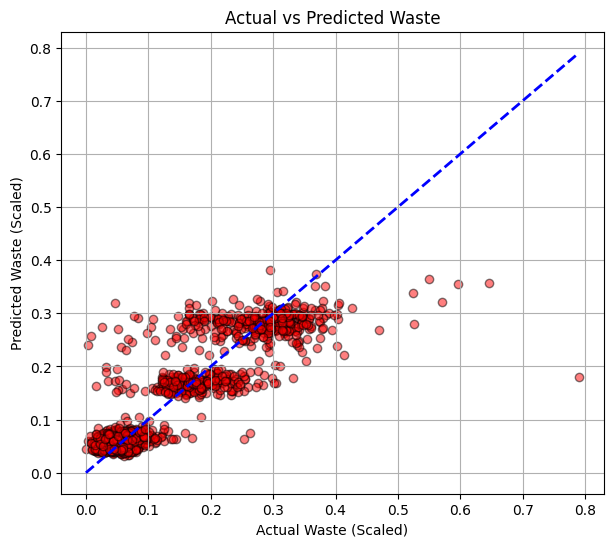

In [20]:
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.5, color="red", edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2) 
plt.xlabel("Actual Waste (Scaled)")
plt.ylabel("Predicted Waste (Scaled)")
plt.title("Actual vs Predicted Waste")
plt.grid(True)
plt.show()


**PREDICT FUTURE WASTE VOLUME**

In [39]:
import pandas as pd
from prophet import Prophet
city = 'moratuwa'
data_city = data[data['city'] == city][['ticket_date', 'net_weight_kg']].copy()
data_city.rename(columns={'ticket_date': 'ds', 'net_weight_kg': 'y'}, inplace=True)
model = Prophet(daily_seasonality=True)
model.fit(data_city)
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)
future_forecast = forecast[['ds', 'yhat']].tail(7)
future_forecast.rename(columns={'ds': 'Date', 'yhat': 'Predicted_Waste'}, inplace=True)

print(future_forecast)


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\fastf\AppData\Local\Temp\tmprftndrn5\ixrifyou.json
DEBUG:cmdstanpy:input tempfile: C:\Users\fastf\AppData\Local\Temp\tmprftndrn5\livkz_d_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\fastf\\AppData\\Roaming\\Python\\Python312\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=36158', 'data', 'file=C:\\Users\\fastf\\AppData\\Local\\Temp\\tmprftndrn5\\ixrifyou.json', 'init=C:\\Users\\fastf\\AppData\\Local\\Temp\\tmprftndrn5\\livkz_d_.json', 'output', 'file=C:\\Users\\fastf\\AppData\\Local\\Temp\\tmprftndrn5\\prophet_modelp5eb29rh\\prophet_model-20250826113340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:33:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:33:41 - cmdstanpy - INFO - Chain [1] done

           Date  Predicted_Waste
1376 2018-12-12     17807.546947
1377 2018-12-13     19564.891247
1378 2018-12-14     17695.607154
1379 2018-12-15     23240.535652
1380 2018-12-16     24198.402680
1381 2018-12-17     18940.307398
1382 2018-12-18     19027.921305


In [40]:
# Assume forecast has 7 predicted values in 'yhat'
predicted_values = forecast[['yhat']].tail(7).reset_index(drop=True)
future_days = pd.date_range(start='2025-08-27', periods=7)
future_forecast = pd.DataFrame({
    'Date': future_days,
    'Predicted_Waste': predicted_values['yhat']
})

print(future_forecast)


        Date  Predicted_Waste
0 2025-08-27     17807.546947
1 2025-08-28     19564.891247
2 2025-08-29     17695.607154
3 2025-08-30     23240.535652
4 2025-08-31     24198.402680
5 2025-09-01     18940.307398
6 2025-09-02     19027.921305


**OPTIMIZE WASTE COLLECTION SCHEDULE**

In [42]:
import pandas as pd
import math

future_forecast = pd.DataFrame({
    'Date': pd.date_range('2025-08-27', periods=7),
    'Predicted_Waste': [90000, 85000, 92000, 88000, 95000, 97000, 93000]  
})

truck_capacity = 50000 
future_forecast['Trucks_Required'] = future_forecast['Predicted_Waste'].apply(
    lambda x: math.ceil(x / truck_capacity)
)

print(future_forecast)


        Date  Predicted_Waste  Trucks_Required
0 2025-08-27            90000                2
1 2025-08-28            85000                2
2 2025-08-29            92000                2
3 2025-08-30            88000                2
4 2025-08-31            95000                2
5 2025-09-01            97000                2
6 2025-09-02            93000                2


**RESOURCES ALLOCATION**

In [44]:

import math
data = {
    'city': ['moratuwa', 'boralasgamuwa', 'dehiwala', 'homagama'],
    'Predicted_Waste': [92000, 48000, 75000, 60000]
}
df = pd.DataFrame(data)
truck_capacity = 50000  
staff_per_truck = 3     
drivers_per_truck = 1  
df['Trucks_Required'] = df['Predicted_Waste'].apply(lambda x: math.ceil(x / truck_capacity))
df['Staff_Required'] = df['Trucks_Required'] * staff_per_truck
df['Drivers_Required'] = df['Trucks_Required'] * drivers_per_truck
print(df)


            city  Predicted_Waste  Trucks_Required  Staff_Required  \
0       moratuwa            92000                2               6   
1  boralasgamuwa            48000                1               3   
2       dehiwala            75000                2               6   
3       homagama            60000                2               6   

   Drivers_Required  
0                 2  
1                 1  
2                 2  
3                 2  


**VISUALIZATION OF MODEL**

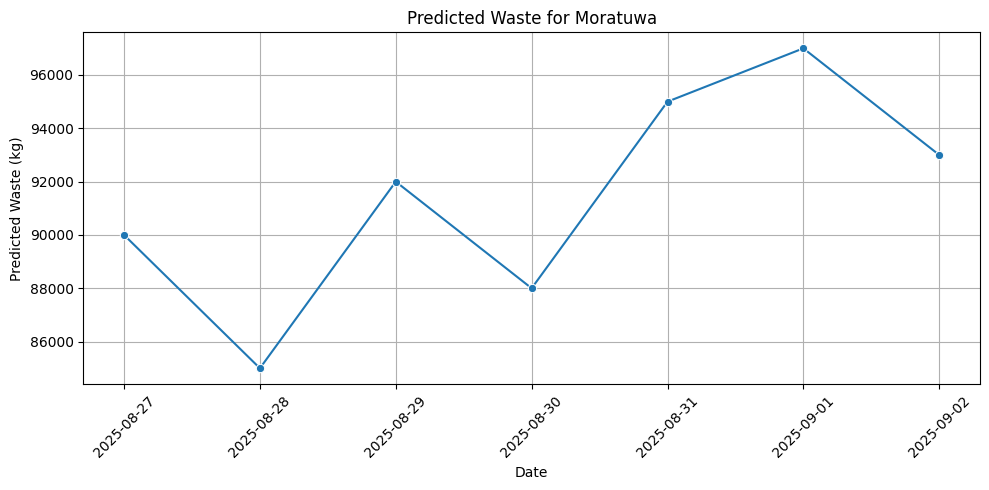

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(data=future_forecast, x='Date', y='Predicted_Waste', marker='o')
plt.title('Predicted Waste for Moratuwa')
plt.xlabel('Date')
plt.ylabel('Predicted Waste (kg)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

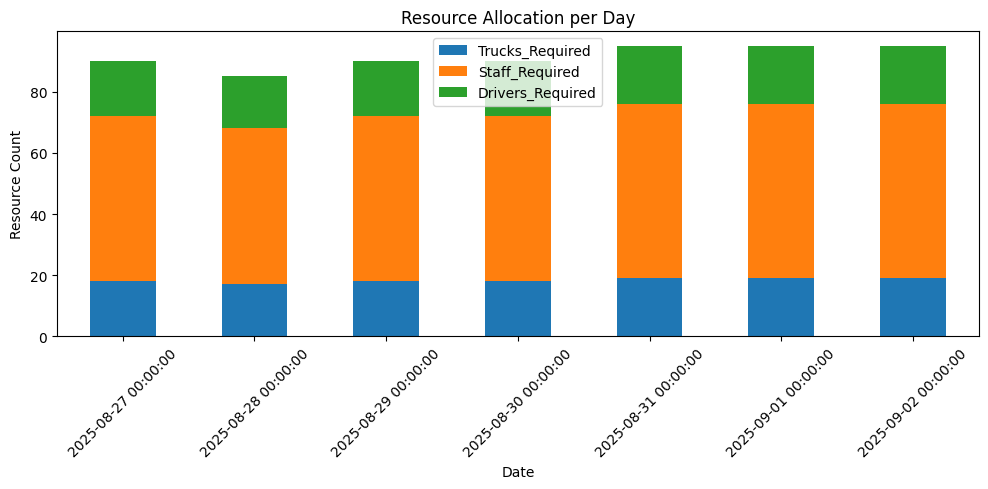

In [63]:
import matplotlib.pyplot as plt
resource_plot = resource_forecast[['Date', 'Trucks_Required', 'Staff_Required', 'Drivers_Required']]
resource_plot = resource_plot.set_index('Date')
resource_plot.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Resource Allocation per Day')
plt.xlabel('Date')
plt.ylabel('Resource Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**SAVE THE MODEL**

In [69]:
import pickle
with open("waste_forecast_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as waste_forecast_model.pkl")


Model saved as waste_forecast_model.pkl


In [70]:
import pickle

with open("waste_forecast_model.pkl", "rb") as f:
    model = pickle.load(f)

print("Model loaded successfully!")


Model loaded successfully!
